# Logistic Regression with regularization

##### This is a starter code  for "ridge regularization" without variable selection strategy, variable selection should be picked from basic notebook.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
get_ipython().magic(u'matplotlib inline')
import matplotlib
import matplotlib.pyplot as plt
from itertools import cycle
from IPython.display import display, HTML
import warnings


In [2]:
warnings.filterwarnings('ignore')
pd.set_option('chained_assignment',None)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,log_loss,f1_score,auc,roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
# from future_encoders import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

### 1. read-data from local - variation of titanic dataset from kaggle

In [4]:
# url="https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv"
data =pd.read_csv('train_grdcv_titanic.csv',sep=',')

In [5]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 2. simple data  assessment

In [6]:
var_names = list(data.columns)
print ("# of rows {}".format(data.shape[0]))

# of rows 891


In [7]:
# event rate in the data
print ("event rate : {:.2f}".format(sum(data['Survived']/data.shape[0])))

event rate : 0.38


The model has relatively high incidence rate - 38%,therefore we may not need to balance the sample,therefore,model will work with "un-balanced" sample.

In [8]:
var_names =list(data.columns)
print(var_names)

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [9]:
data["Pclass"]=data["Pclass"].astype("object")

In [10]:
# numeric_vars
num_vars = [key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['float64','float32','int32','int64']] 

# cat_vars
cat_vars = [key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['object'] ] 

In [11]:
print ("list of num vars {}".format(num_vars))
print ("list of cat vars  {}".format(cat_vars))

list of num vars ['PassengerId', 'Survived', 'Age', 'SibSp', 'Parch', 'Fare']
list of cat vars  ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


#### re-order vars to make use the train test function

In [12]:
data=data[['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked',
           'PassengerId','Pclass', 'Age', 'SibSp', 'Parch', 'Fare','Survived']]

In [13]:
data.head()

,Name,Sex,Ticket,Cabin,Embarked,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S,1,3,22.0,1,0,7.2500,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C,2,1,38.0,1,0,71.2833,1
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S,3,3,26.0,0,0,7.9250,1
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S,4,1,35.0,1,0,53.1000,1
4,"Allen, Mr. William Henry",male,373450,NaN,S,5,3,35.0,0,0,8.0500,0


### 3. set training and test data

In [14]:
n_rows =data.shape[0]
# picke 50% sample
percent_train =0.80
n_train = int(percent_train*n_rows)
print(n_train)

712


In [15]:
def split_data(n_train,data):
    np.random.seed(123)
    perm = np.random.permutation(data.shape[0])
    training_indices = perm[range(0,n_train)]
    test_indices = perm[range(n_train,data.shape[0])]
    x =data.iloc[:,0:-1]
    y =data.iloc[:,len(var_names)-1]
    trainx = x.iloc[training_indices,:]
    trainy = y.iloc[training_indices]
    testx = x.iloc[test_indices,:]
    testy = y.iloc[test_indices]
    return trainx, trainy, testx, testy

#####  train and test dataset is a **Pandas Dataframe** not *numpy* arrays

In [16]:
trainx, trainy, testx, testy=split_data(n_train,data)

### 3. Selected Features

This work does not do have var-selection section to be copied from basic work in the same repo.

In [17]:
trainx['Age']=trainx['Age'].fillna(23)
testx['Age']=testx['Age'].fillna(23)
trainx['IsMinor']=np.where(trainx['Age']<=16, 1, 0)
testx['IsMinor']=np.where(testx['Age']<=16, 1, 0)
selected_vars =["Pclass","Embarked","Sex",'IsMinor','Age','Fare']
print(selected_vars)

['Pclass', 'Embarked', 'Sex', 'IsMinor', 'Age', 'Fare']


### 3.Set Pipeline for a simple model

In [18]:
# Please note columns transformer does accpet the reaminder so putting all variables in some of the groups.

In [19]:
num_vars_model=[x for x in selected_vars if x in num_vars]
cat_vars_model =[x for x in selected_vars if x in cat_vars]+['IsMinor']
print(num_vars_model)
print(cat_vars_model)

['Age', 'Fare']
['Pclass', 'Embarked', 'Sex', 'IsMinor']


### Set Pipeline Transformer

In [20]:
# make data with relevant variables
X_train =trainx[selected_vars]
X_test  =testx[selected_vars]

y_train = trainy
y_test  = testy

In [21]:
# help(ColumnTransformer)

In [22]:
# Setting Transformation for Numeric Variables
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())])

# Setting Transformation for Cat Variables
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Merging both steps to apply on columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars_model),
        ('cat', categorical_transformer, cat_vars_model)])

# Model Pipeline
logmodel = Pipeline(steps=[('preprocessor', preprocessor),('classifier', LogisticRegression(solver='lbfgs'))])


### Fit Model

In [23]:
#Fit the Model
logmodel.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

### Evaluate Model

#### Coefficients and Intercept 

In [24]:
classifier = logmodel.named_steps['classifier']

In [25]:
print ("Model Coef are {}:".format(classifier.coef_))
print ("Model Intercept is {}:".format(classifier.intercept_))

Model Coef are [[-0.1964562   0.02225007  0.89386412  0.16793101 -1.06204672  0.27520844
  -0.04217432 -0.33606259  0.10277688  1.20648548 -1.20673707 -0.3279008
   0.32764921]]:
Model Intercept is [0.42214446]:


##### Evaluate Model : Accuracy

In [26]:
print ("model train score: %.3f" % logmodel.score(X_train, y_train))
print("model test score: %.3f" % logmodel.score(X_test, y_test))


model train score: 0.806
model test score: 0.793


##### Evaluate Model : F-Score

In [27]:
print ("model train f1_score: %.3f"%(f1_score(y_train,logmodel.predict(X_train))))
print ("model test f1_score: %.3f"%(f1_score(y_test,logmodel.predict(X_test))))

model train f1_score: 0.711
model test f1_score: 0.748


##### Evaluate Model : Log Loss

In [28]:
print ("model train Log Loss: %.3f"%(log_loss(y_train,logmodel.predict_proba(X_train))))
print ("model test Log Loss: %.3f"%(log_loss(y_test,logmodel.predict_proba(X_test))))

model train Log Loss: 0.450
model test Log Loss: 0.443


##### Evaluate Model : ROC

In [29]:
fpr_train, tpr_train, thr_train=roc_curve(y_train,logmodel.predict_proba(X_train)[:,1:])
fpr_test,tpr_test, thr_test= roc_curve(y_test,logmodel.predict_proba(X_test)[:,1:])
auc_train = auc(fpr_train,tpr_train)
auc_test =auc(fpr_test,tpr_test)

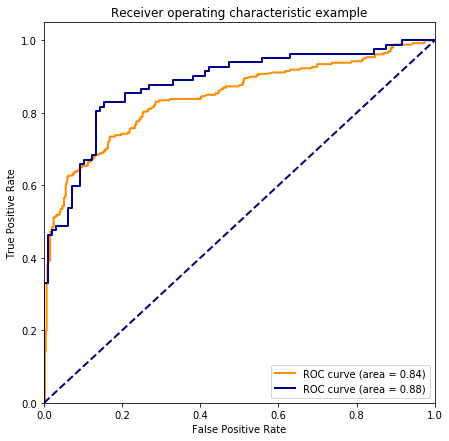

In [30]:
lw=2
f,ax =plt.subplots(1,1,figsize=(7,7))
ax.plot(fpr_train, tpr_train, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' %auc_train)
ax.plot(fpr_test, tpr_test, color='darkblue',lw=lw, label='ROC curve (area = %0.2f)' %auc_test)
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")
plt.show()

### 3.Set Pipeline for a l2-regularization with cross_val_score

### **l2** value for scikit learn different from usual theory please look at the following items

1. Case I 
 - Lambda Small 
 - Circle Big 
 - C Big 
 - Towards MLE 
 - Weak Regularization 
 - Loss Minimum 
2. Case II 
 - Lambda Big
 - Circle Small
 - C Small 
 - Towards Orirgin
 - Strong  Regularization 
 - Loss Bigger

In [31]:
lambdas =np.geomspace(1e-4, 1e4, num=9)
scikit_cs=[x**(-1) for x in lambdas]

In [32]:
logit_pipe_cv =Pipeline(steps=[('preprocessor', preprocessor),('classifier',
                                             LogisticRegression(solver='lbfgs',max_iter=2000,penalty='l2'))])

In [33]:
param={'classifier__C':scikit_cs}

In [34]:
list_log_loss_score =[]
list_roc_score=[]
list_f1_score=[]
for k,v in param.items():
    for val in v:
        logit_pipe_cv.set_params(**{k:val})
        score_log_loss=cross_val_score(logit_pipe_cv, X_train, y_train, cv=10, scoring='neg_log_loss')
        score_roc=cross_val_score(logit_pipe_cv, X_train, y_train, cv=10, scoring='roc_auc')
        score_f1=cross_val_score(logit_pipe_cv, X_train, y_train, cv=10, scoring='f1')
        list_log_loss_score.append(-1*score_log_loss.mean())
        list_roc_score.append(score_roc.mean())
        list_f1_score.append(score_f1.mean())

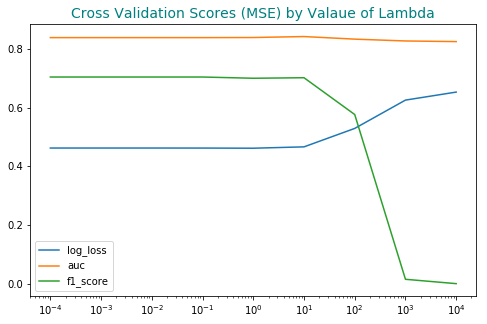

In [35]:
f,ax =plt.subplots(1,1,figsize=(8,5))
ax.plot(lambdas,list_log_loss_score, label="log_loss")
ax.plot(lambdas,list_roc_score,label="auc")
ax.plot(lambdas,list_f1_score,label='f1_score')
ax.set_xscale('log')
ax.set_title("Cross Validation Scores (MSE) by Valaue of Lambda",fontsize=14,color='teal')
ax.legend(loc=0)

In [36]:
print("Best Lambda (Min Logloss)  is {}".format(lambdas[list_log_loss_score.index(min(list_log_loss_score))]))

Best Lambda (Min Logloss)  is 1.0


In [37]:
print("Best Lambda (Max AUC)  is {}".format(lambdas[list_roc_score.index(max(list_roc_score))]))

Best Lambda (Max AUC)  is 10.0


In [38]:
print("Best Lambda (Max f1)  is {}".format(lambdas[list_f1_score.index(max(list_f1_score))]))

Best Lambda (Max f1)  is 0.0001


### 4.pick the best lambda and estimate the model with full train and evaluate on test

In [39]:
logit_pipe_best_lambda =Pipeline(steps=[('preprocessor', preprocessor),('classifier',
                                             LogisticRegression(solver='lbfgs',max_iter=2000,penalty='l2',C=1/0.0001))])

In [40]:
logit_pipe_best_lambda.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...enalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

In [41]:
fpr_train, tpr_train, thr_train=roc_curve(y_train,logit_pipe_best_lambda.predict_proba(X_train)[:,1:])
fpr_test,tpr_test, thr_test= roc_curve(y_test,logit_pipe_best_lambda.predict_proba(X_test)[:,1:])
auc_train = auc(fpr_train,tpr_train)
auc_test =auc(fpr_test,tpr_test)

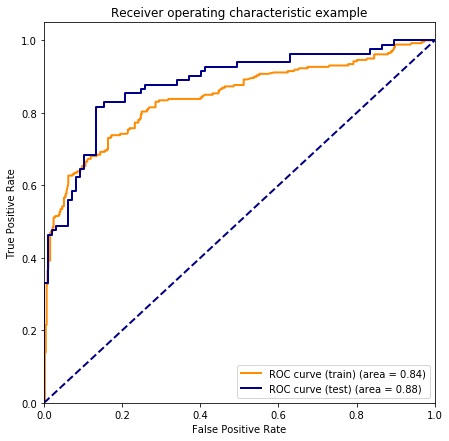

In [42]:
lw=2
f,ax =plt.subplots(1,1,figsize=(7,7))
ax.plot(fpr_train, tpr_train, color='darkorange',lw=lw, label='ROC curve (train) (area = %0.2f)' %auc_train)
ax.plot(fpr_test, tpr_test, color='darkblue',lw=lw, label='ROC curve (test) (area = %0.2f)' %auc_test)
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")
plt.show()

### 5.Apply GridSearch CV - for reference purpose

In [43]:
warnings.filterwarnings('ignore')

In [44]:
log_model_grid_pipe =Pipeline(steps=[('preprocessor', preprocessor),('classifier',
                                             LogisticRegression(solver='lbfgs',max_iter=2000,penalty='l2'))])
cv_folds = 10
param_grid = {'classifier__C': scikit_cs}
scoring={'F_1': 'f1', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}
grid_model =GridSearchCV(log_model_grid_pipe, 
                         param_grid, cv=cv_folds,scoring=scoring, refit=False,verbose=False,return_train_score=True)
grid_model.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__C': [10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score=True,
       scoring={'F_1': 'f1', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'},
       verbose=False)

### Make a list of keys of returned objects

In [45]:
out_metric_ref =sorted(grid_model.cv_results_.keys())
output_data = grid_model.cv_results_

In [46]:
print(out_metric_ref)

['mean_fit_time', 'mean_score_time', 'mean_test_AUC', 'mean_test_F_1', 'mean_test_Log_loss', 'mean_train_AUC', 'mean_train_F_1', 'mean_train_Log_loss', 'param_classifier__C', 'params', 'rank_test_AUC', 'rank_test_F_1', 'rank_test_Log_loss', 'split0_test_AUC', 'split0_test_F_1', 'split0_test_Log_loss', 'split0_train_AUC', 'split0_train_F_1', 'split0_train_Log_loss', 'split1_test_AUC', 'split1_test_F_1', 'split1_test_Log_loss', 'split1_train_AUC', 'split1_train_F_1', 'split1_train_Log_loss', 'split2_test_AUC', 'split2_test_F_1', 'split2_test_Log_loss', 'split2_train_AUC', 'split2_train_F_1', 'split2_train_Log_loss', 'split3_test_AUC', 'split3_test_F_1', 'split3_test_Log_loss', 'split3_train_AUC', 'split3_train_F_1', 'split3_train_Log_loss', 'split4_test_AUC', 'split4_test_F_1', 'split4_test_Log_loss', 'split4_train_AUC', 'split4_train_F_1', 'split4_train_Log_loss', 'split5_test_AUC', 'split5_test_F_1', 'split5_test_Log_loss', 'split5_train_AUC', 'split5_train_F_1', 'split5_train_Log_loss

### It is a good practice to check whether params order input maintained by pipeline object in gridcv

In [47]:
c_vales_in_output =[x for x in output_data ['param_classifier__C']]
c_values_in_input =scikit_cs
for i in range(len(c_vales_in_output)):
    if c_vales_in_output[i]==c_values_in_input[i]:
        if i ==len(c_vales_in_output)-1:
            print("Order Maintained ::TRUE") 
    else:
        print("Order Not Maintained:Possible Error")
        break

Order Maintained ::TRUE


### 6. Plot GridSearch CV results

In [48]:
def best_val_lambda(scr,out_put,lambda_list):
    res_dict ={}
    for x in list(scr.keys()):
        key_make ='mean_'+'test_'+x
        if x=='Log_loss':
                out_list =list(-1*out_put[key_make])
                max_got =min(out_list)
                res_dict[x]=(max_got,lambda_list[out_list.index(max_got)])
        else:
            out_list =list(out_put[key_make])
            max_got =max(out_list)
            res_dict[x]=(max_got,lambda_list[out_list.index(max_got)])
        
    return res_dict

# best_val_lambda(scoring,output_data,lambdas)    

In [49]:
best_val_dict =best_val_lambda(scoring,output_data,lambdas)
best_val_dict

{'F_1': (0.7041526113412415, 0.0001),
 'AUC': (0.8420358748888304, 10.0),
 'Log_loss': (0.4613005789568626, 1.0)}

Text(0.5,1,'GridSerachCV with Multiple Scoring for Ridge Penalty')

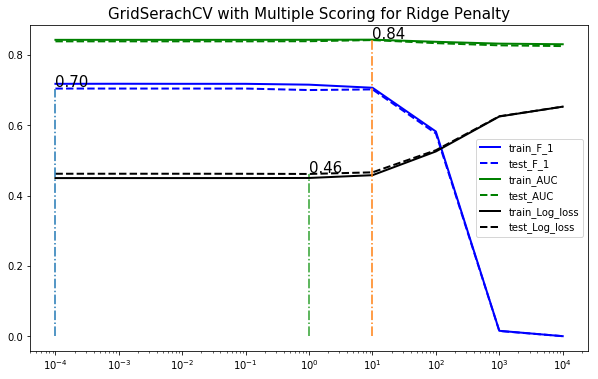

In [50]:
color=['b','g','k']

f,ax =plt.subplots(1,1,figsize=(10,6))
for scr,col in zip(list(scoring.keys()), color):
    # Plot Mean Train and Test for each score
    for t,stl  in zip(['train_','test_'],['-','--']):
        key_make ='mean_'+t+scr
        if scr =='Log_loss':
            ax.plot(lambdas,-1*output_data[key_make],linewidth=2.0,ls=stl,label=t+scr,color=col)
        else:
            ax.plot(lambdas,output_data[key_make],linewidth=2.0,ls=stl,label=t+scr,color=col)
            
for k,v in best_val_dict.items():
    
    ax.plot([v[1],v[1]],[0.0,v[0]],linestyle='-.')
    ax.annotate("%0.2f" % v[0],(v[1], v[0] + 0.005),size=15)
         
ax.set_xscale('log')   
ax.legend(loc="best")    
ax.set_title("GridSerachCV with Multiple Scoring for Ridge Penalty",fontsize=15)

###  Best Lambda Value is similar for K-cross and GridSearch CV